In [12]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

folder = 'drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# インポート
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('GPU:', tf.test.gpu_device_name())

numpy version: 1.17.4
tensorflow version: 1.15.0
GPU: /device:GPU:0


In [0]:
# データ読み込み関数
def loadData(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    time = data[:, 0].astype('f8')
    speed = data[:, 1].astype('f8')
    speed = speed[:, np.newaxis]
    xyzwave_list = []
    for row in data:
        xyzwave = []
        xyzwave.append(row[2:52].astype('f8'))
        xyzwave.append(row[52:102].astype('f8'))
        xyzwave.append(row[102:152].astype('f8'))
        xyzwave_list.append(xyzwave)
    xyzwave_list = np.asarray(xyzwave_list)
    xyzwave_list = xyzwave_list[:, :, :, np.newaxis]
    return time, xyzwave_list, speed

In [0]:
# 学習データとテストデータに分割
def splitData(time, x, t, ratio=0.9):
    border = int(len(x) * ratio)
    return (time[:border], x[:border], t[:border]), (time[border:], x[border:], t[border:])

In [0]:
# データの読み込み
time, acc, speed = loadData(folder + 'data/ML/1121_1625.csv')

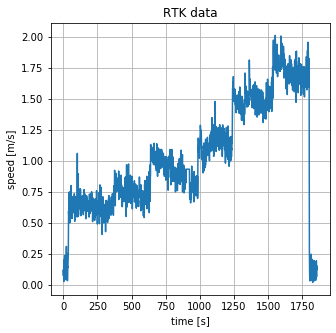

In [17]:
plt.figure(figsize=(5, 5), facecolor='white')
plt.plot(speed)
plt.title('RTK data')
plt.xlabel('time [s]')
plt.ylabel('speed [m/s]')
plt.grid()

In [0]:
MAX_SPEED = 2.5
speed = speed / MAX_SPEED

# シャッフル
zipped = list(zip(time, acc, speed))
np.random.shuffle(zipped)
time, acc, speed = zip(*zipped)
time = np.asarray(time)
acc = np.asarray(acc)
speed = np.asarray(speed)

# 分割
(time_train, x_train, t_train), (time_test, x_test, t_test) = splitData(time, acc, speed)

In [0]:
# ハイパーパラメータ
activation = 'relu'
activation_output = 'sigmoid'
learning_rate = 0.001
optimizer  ='adam'
loss = 'mse'

In [0]:
# モデル生成
model = keras.Sequential()
model.add(layers.Input(shape=(3, 50, 1)))
model.add(layers.Conv2D(10, (3, 3), padding='same', activation=activation))
model.add(layers.Conv2D(10, (3, 3), padding='same', activation=activation))
model.add(layers.Conv2D(10, (3, 3), padding='same', activation=activation))
model.add(layers.Flatten())
model.add(layers.Dense( 50, activation=activation))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(  1, activation=activation_output))

adam = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam, loss=loss)

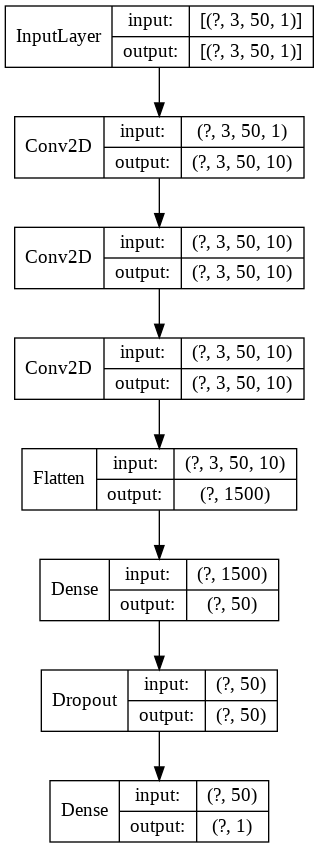

In [21]:
# モデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=folder+'graph/model.png',
           show_shapes=True, show_layer_names=False)

In [22]:
# モデルの訓練
result = model.fit(x_train, t_train, epochs=50)

Train on 1673 samples
Epoch 1/50
1673/1673 [==============================] - 7s 4ms/sample - loss: 0.0149
Epoch 2/50
1673/1673 [==============================] - 0s 113us/sample - loss: 0.0028
Epoch 3/50
1673/1673 [==============================] - 0s 151us/sample - loss: 0.0024
Epoch 4/50
1673/1673 [==============================] - 0s 137us/sample - loss: 0.0019
Epoch 5/50
1673/1673 [==============================] - 0s 109us/sample - loss: 0.0018
Epoch 6/50
1673/1673 [==============================] - 0s 126us/sample - loss: 0.0018
Epoch 7/50
1673/1673 [==============================] - 0s 117us/sample - loss: 0.0016
Epoch 8/50
1673/1673 [==============================] - 0s 143us/sample - loss: 0.0015
Epoch 9/50
1673/1673 [==============================] - 0s 120us/sample - loss: 0.0015
Epoch 10/50
1673/1673 [==============================] - 0s 111us/sample - loss: 0.0015
Epoch 11/50
1673/1673 [==============================] - 0s 115us/sample - loss: 0.0014
Epoch 12/50
1673/1673

In [0]:
# 学習データでテスト
y_train = model.predict(x_train)
t_train = t_train * MAX_SPEED
y_train = y_train * MAX_SPEED
error_train = np.abs(t_train - y_train)

# テストデータでテスト
y_test = model.predict(x_test)
t_test = t_test * MAX_SPEED
y_test = y_test * MAX_SPEED
error_test  = np.abs(t_test - y_test)

In [24]:
# 誤差表示
error_rate_train = np.average(error_train) / np.average(t_train) * 100
error_rate_test  = np.average(error_test)  / np.average(t_test)  * 100
print('error_train_average = {} [%]'.format(error_rate_train))
print('error_test_average  = {} [%]'.format(error_rate_test))

error_train_average = 2.9707094594358847 [%]
error_test_average  = 6.652464780033256 [%]


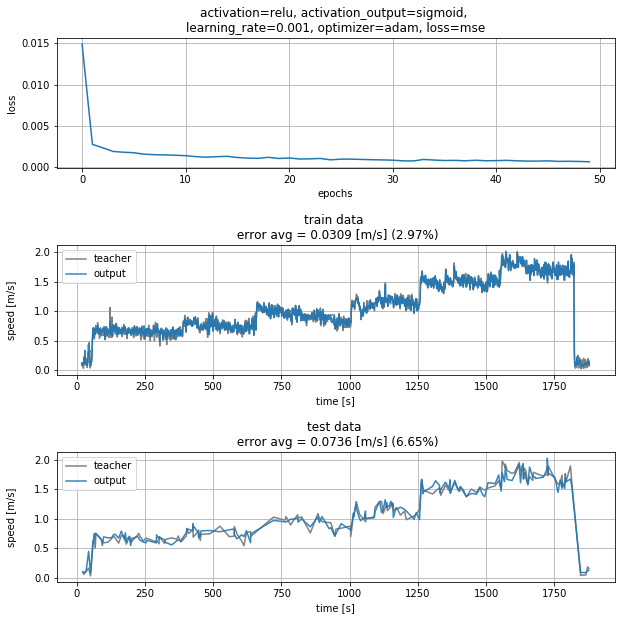

In [25]:
# グラフ表示
fig = plt.figure(figsize=(10, 10), facecolor='white')

ax1 = fig.add_subplot(311)
ax1.set_title('activation={}, '.format(activation) + 
              'activation_output={}, \n'.format(activation_output) + 
              'learning_rate={}, '.format(learning_rate) +
              'optimizer={}, '.format(optimizer) + 
              'loss={}'.format(loss))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(result.history['loss'], label="training")
ax1.grid()

ax2 = fig.add_subplot(312)
ax2.set_title('train data \n error avg = {0:.3} [m/s] ({1:.3}%)' \
              .format(np.average(error_train), error_rate_train))
ax2.set_xlabel('time [s]')
ax2.set_ylabel('speed [m/s]')

zipped = zip(time_train, t_train, y_train, error_train)
zipped = sorted(zipped)
time_train, t_train, y_train, error_train = zip(*zipped)

ax2.plot(time_train, t_train, color='gray', label='teacher')
ax2.plot(time_train, y_train, label='output', alpha=0.9)
# ax2.plot(time_train, error_train, color='red', label='error', alpha=0.5)
ax2.legend(loc='upper left')
ax2.grid()

ax3 = fig.add_subplot(313, sharex=ax2)
ax3.set_title('test data \n error avg = {0:.3} [m/s] ({1:.3}%)' \
              .format(np.average(error_test), error_rate_test))
ax3.set_xlabel('time [s]')
ax3.set_ylabel('speed [m/s]')

zipped = zip(time_test, t_test, y_test, error_test)
zipped = sorted(zipped)
time_test, t_test, y_test, error_test = zip(*zipped)

ax3.plot(time_test, t_test, color='gray', label='teacher')
ax3.plot(time_test, y_test, label='output', alpha=0.9)
# ax3.plot(time_test, error_test, color='red', label='error', alpha=0.5)
ax3.legend(loc='upper left')
ax3.grid()

fig.align_labels()
fig.subplots_adjust(hspace=0.6)
fig.savefig(folder + 'graph/graph.png')

In [0]:
time_test2, x_test2, t_test2 = loadData(folder + 'data/ML/1106_1152.csv')

# テストデータでテスト
y_test2 = model.predict(x_test2)
y_test2 = y_test2 * MAX_SPEED
error_test2 = np.abs(t_test2 - y_test2)

In [27]:
error_rate_test2  = np.average(error_test2)  / np.average(t_test2)  * 100
print('error_test2_average  = {} [%]'.format(error_rate_test2))

error_test2_average  = 9.083260238348691 [%]


In [0]:
speed_list = []
for row in x_test2[:, 0, :, :]:
    speed = (max(row) - min(row)) ** (1/4)
    speed_list.append(speed)

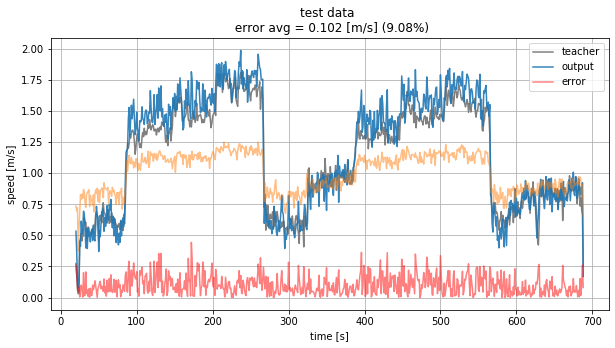

In [29]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.title('test data \n error avg = {0:.3} [m/s] ({1:.3}%)' \
              .format(np.average(error_test2), error_rate_test2))
plt.xlabel('time [s]')
plt.ylabel('speed [m/s]')
plt.plot(time_test2, t_test2, color='gray', label='teacher')
plt.plot(time_test2, y_test2, label='output', alpha=0.9)
plt.plot(time_test2, error_test2, color='red', label='error', alpha=0.5)
plt.plot(time_test2, speed_list, alpha=0.5)
plt.legend()
plt.grid()